In [1]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

In [2]:
dir = '/Users/Loielaine/Desktop/umich-2019/EECS545/hw2/'

## 1. KNN

In [3]:
def SplitXy(df):
    df_encode = pd.get_dummies(df,prefix=['species'])
    X = df_encode[['sepal_length', 'sepal_width', 'petal_length','petal_width']].values.T
    Y = df_encode[['species_setosa', 'species_versicolor','species_virginica']].values.reshape((-1,3))
    return X, Y
    
def FindKNearestNeighbors(X,Y,x,k):
    n,c = Y.shape 
    Xnew = np.hstack((X,x.reshape((-1,1))))
    #print(Xnew.shape)
    y0 = np.zeros((1,c))
    Ynew = np.vstack((Y, y0))
    #print(Ynew.shape)
    xx = np.dot(np.transpose(Xnew), Xnew)
    d = np.diag(xx)
    #print(d)
    d_x = np.tile(d[n],n+1)
    D = d_x - 2*xx[:,n] + d
    index = np.argsort(D,axis=0).reshape((-1,1))
    Y_sort = np.take_along_axis(Ynew,index,axis=0)
    #print(Y_sort)
    KNN = Y_sort[1:k+1,:]
    vote = np.sum(KNN,axis=0)
    #print(vote)
    majority = np.argmax(vote)
    return majority+1

def ObtainMisclassificationRate(y_predicted, y_test_encode):
    rate = float(sum(y_predicted == y_test_encode))/float(len(y_test_encode))
    return rate

In [4]:
train = pd.read_csv(dir+'iris.train.csv')
test = pd.read_csv(dir+'iris.test.csv')

In [5]:
X_train, Y_train = SplitXy(train)
X_test, Y_test = SplitXy(test)

In [6]:
Y_test[:,0] = Y_test[:,0] * 1
Y_test[:,1] = Y_test[:,1] * 2
Y_test[:,2] = Y_test[:,2] * 3
Y_test_encode = np.sum(Y_test, axis = 1)

In [7]:
p,n = X_test.shape
accuracy = []
for k in range(1,51):
    y_predicted = []
    for i in range(0,n):
        majority = FindKNearestNeighbors(X_train, Y_train, X_test[:,i],k)
        y_predicted.append(majority)
    rate = ObtainMisclassificationRate(y_predicted, Y_test_encode)
    accuracy.append(rate)

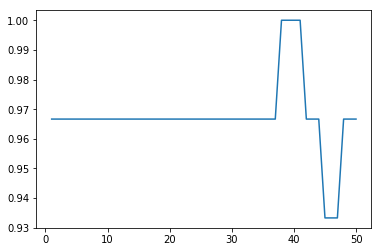

In [8]:
plt.plot(range(1,51), accuracy)
plt.show()

## 2. Regularized Linear Regression

In [9]:
def SolvePenalizedLinearRegression(X, y, c):
    p,n = X.shape 
    X0 = np.ones((1,n))
    Xnew = np.vstack((X0,X))
    xy = np.dot(Xnew, y) #(p+1)*1
    xx = np.dot(Xnew, np.transpose(Xnew))
    identity = np.identity(p+1)
    identity[0,0] = 0
    mat = identity * c + xx #(p+1)*(p+1)
    matinv = np.linalg.inv(mat) #(p+1)*(p+1)
    w = np.dot(matinv, xy) 
    return w

def CalculateMeanSquareError(X, y, w):
    p,n = X.shape 
    X0 = np.ones((1,n))
    Xnew = np.vstack((X0,X))
    y_predict = np.dot(np.transpose(Xnew),w)
    error = np.dot(np.transpose(Xnew),w) - y
    MSE = np.mean(np.sum(error**2))/n
    return y_predict, MSE

In [12]:
bodyfat = scipy.io.loadmat(dir+'bodyfat_data.mat')
X = bodyfat['X'].T
X_train = X[:,0:150]
X_test = X[:,150:]
y = bodyfat['y']
y_train = y[0:150,:]
y_test = y[150:,:]

In [13]:
# c = 10
w = SolvePenalizedLinearRegression(X_train, y_train, 10)
print(w)

[[-23.35089988]
 [  0.91197543]
 [ -0.41254858]]


In [14]:
y_predict, MSE = CalculateMeanSquareError(X_test , y_test, w)
print(MSE)

22.246171649654627


In [15]:
print(y_predict.T)

[[ 5.45773562 17.81070804 24.62023955 12.24552293 28.51135114 17.17023952
   9.45955541 19.94955566 12.95330979 20.47509527 17.94325899 15.74349804
  28.43320998 20.2666367  19.65203455 24.15124474 36.18286612 18.98545327
  13.05537944 18.28193641 17.78687811 28.67646912 12.26061575 12.7557726
  30.25070656 19.15052198 26.61144339 26.7438958  15.10079596 16.16264872
  19.69328941 12.51042773 31.44272889 23.89716276 24.02524661 26.40725483
  12.07608567 33.97024589 20.09724872 26.92197161 14.90325877 23.24353931
  15.39181352 16.78588942  6.94087406 19.59121977 17.07248915 14.82943688
  27.14989155 15.57862643 36.33914845 22.39237867 20.98747994 27.07602039
  15.29187887 14.84025971 12.34312547 26.5267494  17.56973172 22.67033985
  16.89222906 41.46582006 10.88187906 12.03051153 24.52904201 18.55547976
  20.68127101 33.80731218 17.09850335 14.24745104 23.04808785 11.86757783
  19.67159448 20.85944537 17.5849231  21.44560266 18.27315003 23.29348199
  16.64688419 21.85820051 22.95684103 2

## 3. Newton method

In [16]:
def ExpTerm(t):
    return np.exp(-t)

def Gradient(X, y, theta, c):
    p,n = X.shape
    ythetax = theta.transpose().dot(X) * y #n*n 
    g1= X.dot((ExpTerm(ythetax)/(1+ ExpTerm(ythetax))*(-y)).transpose())
    #print(g1.shape)
    g2 = 2 * c * theta
    g = g1 + g2
    return g #(p+1)*1
    
def Hessian(X, y, theta, c):
    p,n = X.shape
    ythetax = (theta.T.dot(X))*y #n*n 
    sig = (ExpTerm(ythetax)/(1+ExpTerm(ythetax))**2)*X
    h1 = sig.dot(X.transpose())
    h2 = 2 * c * np.identity(p)
    h = h1 + h2
    return h.reshape((p,p)) #(p+1)*(p+1)

    
def SolveRegularizedNewtonMethod(X, y, eta, eps, c, theta0, max_iterarion):
    p,n = X.shape 
    X0 = np.ones((1,n))
    Xnew = np.vstack((X0,X))
    i = 0
    for i in range(max_iterarion):
        g = Gradient(Xnew, y, theta0, c) #(p+1)*1
        #print(g.shape)
        h = Hessian(Xnew, y, theta0, c)
        hinv =  np.linalg.inv(h) #(p+1)*(p+1)
        #print(hinv.shape)
        theta = theta0 - eta * np.dot(hinv, g)
        i = i+1
        print('Iteration: %d' %i)
        change = np.linalg.norm(theta - theta0)
        print(change)
        if change < eps:
            theta0 = theta
            break;
        else: 
            theta0 = theta  
    return theta

def CalculateAccuracy(X, y, theta):
    p,n = X.shape 
    X0 = np.ones((1,n))
    Xnew = np.vstack((X0,X))
    xtheta = theta.T.dot(Xnew) #n*1
    y_predicted = 1/(1+ExpTerm(xtheta)) 
    y_predicted = y_predicted >0.5 
    #print(y_predicted)
    accuracy = np.mean(y_predicted == y)
    print("The error rate is %f" %(1-accuracy))
    return accuracy

def CalculateConfidence(X, y, theta):
    p,n = X.shape 
    X0 = np.ones((1,n))
    Xnew = np.vstack((X0,X))
    xtheta = theta.T.dot(Xnew) #n*1
    y_predicted = 1/(1+ExpTerm(xtheta)) 
    y_predicted = y_predicted >0.5 
    y_test = y==1
    x_incorrect = X[:,(y_predicted != y_test).reshape(n,)]
    y_incorrect = y[y_predicted != y_test].reshape(1,-1)
    x_incorrect_new = np.vstack((np.ones(x_incorrect.shape[1]),x_incorrect))
    x_incorrect_theta = theta.T.dot(x_incorrect_new) 
    prob = 1/(1+ExpTerm(x_incorrect_theta)) 
    confidence = np.abs(prob-0.5)
    #print(confidence)
    prob_sorted = np.take_along_axis(prob,np.argsort(confidence,axis = 1),axis =1)
    print(prob_sorted)
    x_incorrect_sorted = np.take_along_axis(x_incorrect,np.argsort(confidence,axis = 1),axis =1)
    y_incorrect_sorted = np.take_along_axis(y_incorrect,np.argsort(confidence,axis = 1),axis =1)
    return x_incorrect_sorted, y_incorrect_sorted

In [17]:
mnist_49_3000 = scipy.io.loadmat(dir+'mnist_49_3000.mat')
x = mnist_49_3000['x']
y = mnist_49_3000['y']
#y[y<0] = 0
p,n = x.shape

In [18]:
train_x = x[:,0:2000]
test_x = x[:,2000:]
train_y = y[:,0:2000]
test_y = y[:,2000:]

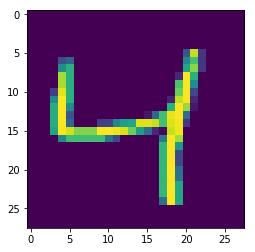

In [19]:
i = 0
plt.imshow(np.reshape(x[:,i], (int(np.sqrt(p)), int(np.sqrt(p)))))
plt.show()

In [20]:
eta = 1
eps = 10**(-6)
c = 10
max_iterarion = 50 
theta0 = np.zeros((x.shape[0]+1,1))
theta = SolveRegularizedNewtonMethod(train_x, train_y, eta, eps, c, theta0, max_iterarion)

Iteration: 1
1.803761906945822
Iteration: 2
0.9051834519010579
Iteration: 3
0.6503886272058389
Iteration: 4
0.24714121992609436
Iteration: 5
0.026775398560232026
Iteration: 6
0.00030279348585199203
Iteration: 7
4.349048504533124e-08


In [21]:
theta.shape

(785, 1)

In [22]:
accuracy = CalculateAccuracy(test_x, test_y==1 , theta)

The error rate is 0.048000


In [23]:
x_incorrect_sorted, y_incorrect_sorted = CalculateConfidence(test_x, test_y, theta)

[[0.4937767  0.50935997 0.48359895 0.52006858 0.52404661 0.45603301
  0.44714906 0.55485895 0.56079569 0.43726036 0.43638443 0.4349028
  0.58620645 0.41153568 0.59358413 0.59720446 0.40230088 0.38585491
  0.37956154 0.37275888 0.62806395 0.62864639 0.35301513 0.65217843
  0.66090595 0.33654197 0.67029023 0.30976266 0.28428003 0.73517472
  0.26420625 0.24087757 0.76410206 0.22807223 0.22659318 0.21949731
  0.21741511 0.20575767 0.19856135 0.17546085 0.83186957 0.15455764
  0.1460306  0.12480475 0.90411236 0.09054923 0.07441565 0.05496435]]


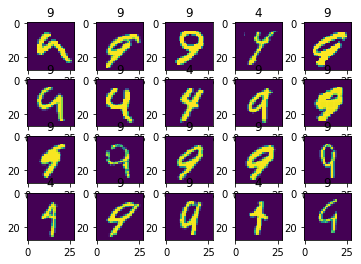

In [24]:
fig, axes = plt.subplots(4,5)
k = -1
for i in range(0,4):
    for j in range(0,5):
        axes[i,j].imshow(np.reshape(x_incorrect_sorted[:,k],(int(np.sqrt(p)),int(np.sqrt(p)))))
        axes[i,j].set_title("9" if y_incorrect_sorted[:,k] == 1 else "4")
        k = k-1
fig